# Inference testing

## Module load

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/julia_codes/SmallCouplingDynamicCavity`


In [2]:
using SmallCouplingDynamicCavity
using Plots, LaTeXStrings
using Graphs, GraphRecipes
using Distributions

[ Info: Precompiling SmallCouplingDynamicCavity [1607259e-80f4-4675-b495-cb9c54bacb3f]


In [3]:
function sort_by_infection_time(X, T, NV)
    inf_tuples = Dict()
    first_time_inf = ones(Int, NV).*(T+1)
    for i=1:NV
        t1 = 0
        t2 = 0
        inf = false
        for t=0:T
            if X[i,t+1]==1.0 && !inf
                t1 = t
                inf = true
            elseif X[i,t+1]==2.0 && inf
                t2 = t
                if !haskey(inf_tuples, i)
                    merge!(inf_tuples, Dict(i=>[(t1,t2)]))
                    first_time_inf[i] = t1
                else
                    push!(inf_tuples[i],(t1,t2))
                end
                inf = false
            else
                continue
            end
        end
        if inf
            if !haskey(inf_tuples, i)
                merge!(inf_tuples, Dict(i=>[(t1,T)]))
                first_time_inf[i] = t1
            else
                push!(inf_tuples[i],(t1,T))
            end
        end
    end
    #display(first_time_inf)
    perm = sortperm(first_time_inf)
    
    return inf_tuples, invperm(perm), perm
end

sort_by_infection_time (generic function with 1 method)

## Graph generation

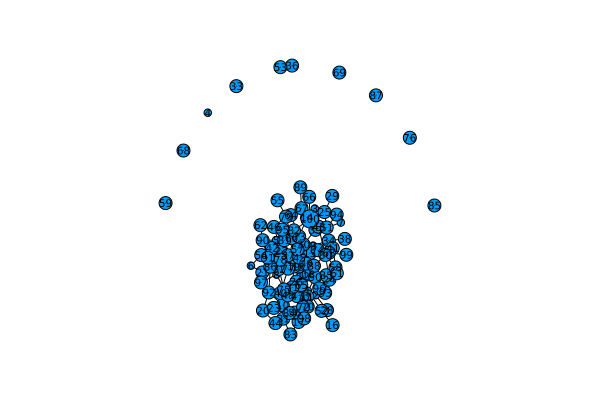

In [38]:
NV = 100 # number of graph vertices
k = 3 # average degree

# generate a random graph with NV vertices and NE edges
#G = random_regular_graph(NV, ceil(Int,k))

#genrate an Erdos-Renyi random graph with average connectivity k
G = erdos_renyi(NV, k/NV)

# generate a random tree
#G = uniform_tree(NV)

# generate a Watts-Strogatz small world random graph with average connectivity k
#G = watts_strogatz(NV, ceil(Int,k), 0.1, remove_edges = true)

# Graph plotting
display(graphplot(G, names=vertices(G), edgecolor=:black,curves=false, nodeshape=:circle, markersize =.15))

## - SIRS: model simulation

### System parameter definition and simulation

sources: [81, 83, 98]


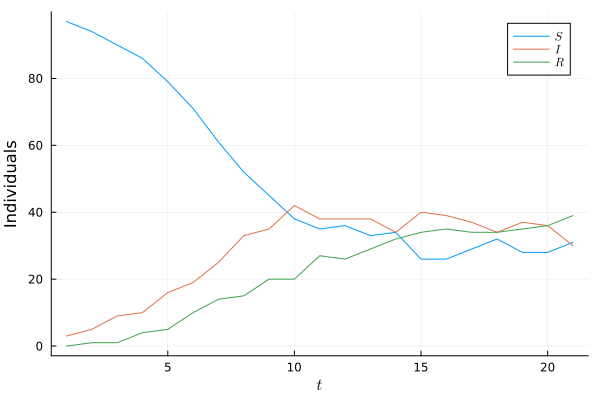

In [39]:
# define the constants
const T::Int = 20 # total time
const fₚ::Float64 = 0.0 # false-positive rate
const fₙ::Float64 = 0.0 # false-negative rate
const γ::Float64 = 1/NV # Patient zero probability
const λ₀::Float64 = 0.4 # Infection rate
const r₀::Float64 = 0.15 # Recovery rate
const σ₀::Float64 = 0.15 # Immunity rate

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1.0
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# constant recovery rate
r = ones(NV, T+1).*r₀

# constant immunity rate
σ = ones(NV, T+1).*σ₀

# epidemic simulation
config = sim_epidemics(G, log.(1 .- λ), T, :SIRS, r = r, σ = σ, γ=γ)
inf_tuples, invperm_sort, perm_sort = sort_by_infection_time(config, T, NV)

isource = findall(x->x==1.0, config[:,1])
println("sources: $(isource)")

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
display(plot([nrS nrI nrR], xlabel = L"t", ylabel = "Individuals", label = [L"S" L"I" L"R"]))

### Generation of observations

In [40]:
const Nobs::Int = ceil(NV*.75) # number of observations

# generate observations
obsmat = ones(nv(G), T+1) * (-1.0)
obslist = []
for (iₗ, τₗ) in sample(collect(zip(1:NV,ones(Int, NV)*ceil(Int, T*.51))), Nobs, replace = false)#sample(collect(Iterators.product(1:NV,ceil(Int,T*.5):T+1)), Nobs, replace = false) #sample(collect(zip(1:NV,ones(Int, NV)*ceil(Int, T*.8))), Nobs, replace = false)
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
    push!(obslist, (iₗ, τₗ-1))
end

In [41]:
println(obslist)

Any[(3, 10), (83, 10), (26, 10), (61, 10), (55, 10), (72, 10), (42, 10), (15, 10), (5, 10), (78, 10), (70, 10), (59, 10), (13, 10), (23, 10), (9, 10), (8, 10), (52, 10), (46, 10), (85, 10), (6, 10), (67, 10), (53, 10), (69, 10), (81, 10), (86, 10), (71, 10), (93, 10), (91, 10), (49, 10), (65, 10), (24, 10), (57, 10), (48, 10), (43, 10), (16, 10), (63, 10), (98, 10), (56, 10), (82, 10), (38, 10), (25, 10), (75, 10), (1, 10), (17, 10), (80, 10), (96, 10), (35, 10), (41, 10), (97, 10), (92, 10), (94, 10), (19, 10), (68, 10), (27, 10), (77, 10), (20, 10), (40, 10), (10, 10), (4, 10), (28, 10), (29, 10), (31, 10), (30, 10), (21, 10), (14, 10), (84, 10), (47, 10), (90, 10), (44, 10), (73, 10), (99, 10), (87, 10), (60, 10), (2, 10), (89, 10)]


## Inference SCDC -- autoinfection, $\mu$ cutoff

In [43]:
# computational constants
const epsconv::Float64 = 5e-15 # convergence threshold
const maxiter::Int = 5e2 # max number of iterations
const damp::Float64 = 0.0 # damping factor
const μ_cutoff::Float64 = -1
const ε_autoinf::Float64 = 1e-10

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(G, λ, obsmat, obsprob, γ, T, maxiter, epsconv, damp, :SIRS, r = r, σ = σ, callback = report, μ_cutoff = μ_cutoff, ε_autoinf = ε_autoinf);

marg_prob_sorted = zeros(NV, T+1, 3)
for inode in nodes
#    marg_prob_sorted[inode.i,:,:] .= inode.marg.m'
    marg_prob_sorted[invperm_sort[inode.i],:,:] .= inode.marg.m'
end
 #marg_prob_sorted = marg_prob_sorted[perm_sort,:,:];

i = 1 ε = 1.1497102848091665
i = 2 ε = 1.7478993805134526
i = 3 ε = 1.7463483820443706
i = 4 ε = 1.3993204986522385
i = 5 ε = 0.6428123122451825
i = 6 ε = 0.4127286527752074
i = 7 ε = 0.424171304823034
i = 8 ε = 0.18443447796494705
i = 9 ε = 0.08726222943877116
i = 10 ε = 0.09155879131627565
i = 11 ε = 0.06927985510246248
i = 

12 ε = 0.019784793583528026
i = 13 ε = 0.01210215456901731
i = 14 ε = 0.005731479742990819
i = 15 ε = 0.0047176817922699454
i = 16 ε = 0.001452622154478278
i = 17 ε = 0.0017231231309887685
i = 18 ε = 0.0004975363023506096
i = 19 ε = 0.000613387773656604
i = 20 ε = 0.00014512207839667557
i = 21 ε = 0.00016781235422513863
i = 22 ε = 4.12568356008558e-5
i = 23 ε = 4.902828924024938e-5
i = 24 ε = 1.460183189427866e-5
i = 25 ε = 1.4880224270985565e-5
i = 26 ε = 6.4367945694643325e-6
i = 27 ε = 3.9645184787273635e-6
i = 28 ε = 2.49608466362794e-6
i = 29 ε = 9.306801650454943e-7
i = 30 ε = 8.648275696687691e-7
i = 31 ε = 2.5439772388669013e-7
i = 32 ε = 2.9572268145372504e-7
i = 33 ε = 8.333159373652421e-8
i = 34 ε = 9.858873639689847e-8
i = 35 ε = 2.5847953999402762e-8
i = 36 ε = 3.095844691713978e-8
i = 37 ε = 7.686268621576176e-9
i = 38 ε = 9.308920856376801e-9
i = 39 ε = 2.221868022900253e-9
i = 40 ε = 2.7307591743408466e-9
i = 41 ε = 9.485849883361652e-10
i = 42 ε = 7.621138164992658e-10

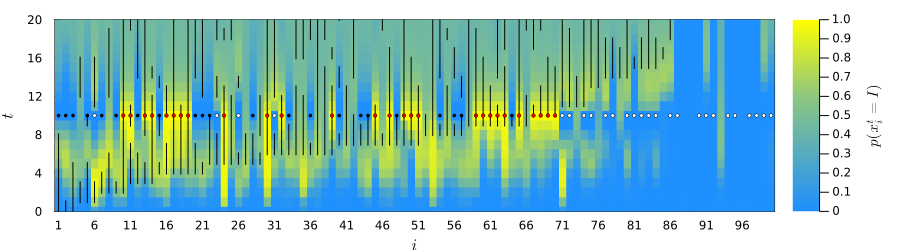

In [44]:
resize_factor = 1.0

cg = cgrad([:dodgerblue, :yellow], 0.6)

plI = heatmap(1:NV, 0:T, marg_prob_sorted[:,:,2]', c=cg, xlabel=L"i", ylabel=L"t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

cols = [:white, :red, :black]
for (i,t) in obslist
    scatter!(plI, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

plot!(plI, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)

display(plI)

## Inference -- no autoinfection, no $\mu$ cutoff

In [46]:
# computational constants
const epsconv::Float64 = 1e-14 # convergence threshold
const maxiter::Int = 5e2 # max number of iterations
const damp::Float64 = 0.0 # damping factor
const μ_cutoff::Float64 = -Inf
const ε_autoinf::Float64 = 0.0

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(G, λ, obsmat, obsprob, γ, T, maxiter, epsconv, damp, :SIRS, r = r, σ = σ, callback = report);

marg_prob_sorted = zeros(NV, T+1, 3)
for inode in nodes
    marg_prob_sorted[invperm_sort[inode.i],:,:] .= inode.marg.m'
end

i = 1 ε = 429.1591027341102
i = 2 ε = 86.74978057886436
i = 3 ε = 86.85432162042284
i = 4 ε = 45.78458520032864
i = 5 ε = 37.31854645378875
i = 6 ε = 46.90112822768887
i = 7 ε = 28.277236356248974
i = 8 ε = 12.855923357374252
i = 9 ε = 16.757005225949285
i = 10 ε = 6.126435187742608
i = 11 ε = 7.153726065799231
i = 12 ε = 31.33867740601803
i = 13 ε = 11.798147970594421
i = 14 ε = 7.156035003498431
i = 15 ε = 32.52587765188002
i = 16 ε = 14.766164538669921
i = 17 ε = 18.047442929245776
i = 18 ε = 21.666471588712277
i = 19 ε = 12.596705954704639
i = 20 ε = 9.117008975658301
i = 21 ε = 19.872120585732475
i = 22 ε = 21.431892310867262
i = 23 ε = 15.666868597823902
i = 24 ε = 7.919200958770677
i = 25 ε = 21.562560966295536
i = 26 ε = 7.590885791476673
i = 27 ε = 9.39330104475021
i = 28 ε = 33.44954129449286
i = 29 ε = 11.84464182063704
i = 30 ε = 2.492534823595932
i = 31 ε = 33.20766496497279
i = 32 ε = 12.233909340266818
i = 33 ε = 6.059691417503926
i = 34 ε = 30.357053321500857
i = 35 ε =

i = 279 ε = 48.88858799927942
i = 280 ε = 48.88858799927948
i = 281 ε = 48.88858799927952
i = 282 ε = 48.888587999279466
i = 283 ε = 48.88858799927942
i = 284 ε = 48.88858799927948
i = 285 ε = 48.888587999279466
i = 286 ε = 48.88858799927941
i = 287 ε = 48.88858799927942
i = 288 ε = 48.88858799927942
i = 289 ε = 48.88858799927943
i = 290 ε = 48.88858799927949
i = 291 ε = 48.888587999279466
i = 292 ε = 48.888587999279466
i = 293 ε = 48.888587999279466
i = 294 ε = 48.88858799927941
i = 295 ε = 48.88858799927943
i = 296 ε = 48.88858799927943
i = 297 ε = 48.888587999279395
i = 298 ε = 48.88858799927945
i = 299 ε = 48.88858799927945
i = 300 ε = 48.888587999279395
i = 301 ε = 48.88858799927944
i = 302 ε = 48.88858799927944
i = 303 ε = 48.88858799927941
i = 304 ε = 48.88858799927941
i = 305 ε = 48.88858799927943
i = 306 ε = 48.88858799927943
i = 307 ε = 48.88858799927942
i = 308 ε = 48.88858799927948
i = 309 ε = 48.88858799927948
i = 310 ε = 48.88858799927942
i = 311 ε = 48.88858799927941
i =

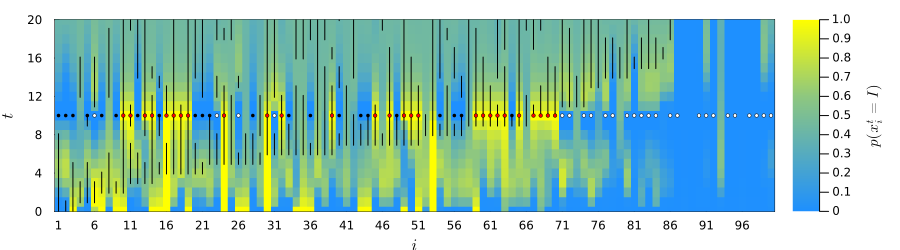

In [47]:
resize_factor = 1.0

cg = cgrad([:dodgerblue, :yellow], 0.6)

plI = heatmap(1:NV, 0:T, marg_prob_sorted[:,:,2]', c=cg, xlabel=L"i", ylabel=L"t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

cols = [:white, :red, :black]
for (i,t) in obslist
    scatter!(plI, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

plot!(plI, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)

display(plI)